# Dataset Generator

The purpose of this notebook is to generate the pairs to be used as dataset for the pairwise boosting algorithm.

## Libraries

In [69]:
import os
from collections import defaultdict
from itertools import combinations

import numpy as np
import pandas as pd

Importing configuration file

In [70]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

In [71]:
%ls

adaboost.ipynb                    fingerprinting-bamboo-test.ipynb
bamboo.ipynb                      generate-bit_masks.ipynb
bamboo_parallel.ipynb             identical-data_binary_pre-processing.ipynb
bamboo_w_data.ipynb               pairwise_boosting.csv
data_binary_pre-processing.ipynb  string_df_pairs_df_generator.ipynb
filter_design.ipynb


In [72]:
%cd ..

from scripts import plotHelper

%cd pairwise_boosting/

/home/bacci/COMPACT/notebooks
/home/bacci/COMPACT/notebooks/pairwise_boosting


/home/bacci/COMPACT/.venv/lib64/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Data

Importing every `CSV` file in the `binary` folder, merge them and create the labelled dataframe.

In [73]:
# Base directory containing the folders
base_dir = config["DEFAULT"]["binary_path"]

# Initialize an empty dictionary to store DataFrames
dataframes = {}

# Traverse the directory structure
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".csv"):
            # Construct the full file path
            file_path = os.path.join(root, file)

            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path, dtype=str)

            # Store the DataFrame in the dictionary with a unique key (e.g., file name)
            dataframes[file] = df

In [74]:
bin_df = pd.concat(dataframes.values(), ignore_index=True)

Set every column's type to string in order to avoid conversions and misrepresentation of the binary data.

In [75]:
bin_df = bin_df.astype(str)

Drop all the Element ID columns, since by definition they are always the same.

In [76]:
# Columns to drop
drop_starts_with = ["e_id_"]
bin_df = bin_df.drop(
    columns=[col for col in bin_df.columns if col.startswith(tuple(drop_starts_with))]
)

In [77]:
bin_df = bin_df.replace("nan", "0")

In [78]:
def zero_pad_column(df, exclude=[]):
    max_lengths = df.drop(columns=exclude).applymap(lambda x: len(str(x))).max()
    for col in df.columns:
        if col not in exclude:
            max_length = max_lengths[col]
            df[col] = df[col].fillna("").astype(str).str.ljust(max_length, "0")
    return df

In [79]:
df = zero_pad_column(bin_df, ["mac", "label"])

/tmp/ipykernel_9397/3590092166.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  max_lengths = df.drop(columns=exclude).applymap(lambda x: len(str(x))).max()


In [80]:
df = df.drop(columns=["frame_check_seq", "len_dsss", "ssid"])

Remove noise within Pintor22 Dataset

In [81]:
df = df[df["mac"] != "00:0f:00:6a:68:8b"]

In [82]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,dsss_parameter,len_ht_cap,ht_cap,len_ext_cap,ext_cap,len_vht_cap,vht_cap,len_vst,vst,len_ext_tags,ext_tags,label
0,22:e4:72:fb:91:70,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000001,00011010,1110111100000001000100111111111111111111000000...,00001100,01111111,0000000000000000000010101000001000000000010000...,1001001011110001100100000011001111111010111111...,00001000,0000000001010000111100100000100000000000001010...,00000011,0000001000000000010001100000000000000000000000...,OppoFindX3Neo_A
1,22:e4:72:fb:91:70,00001110,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000001,00011010,1110111100000001000100111111111111111111000000...,00001100,01111111,0000000000000000000010101000001000000000010000...,1001001011110001100100000011001111111010111111...,00001000,0000000001010000111100100000100000000000001010...,00000011,0000001000000000010001010000000000000000000000...,OppoFindX3Neo_A
2,22:e4:72:fb:91:70,00001100,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000001,00011010,1110111100000001000100111111111111111111000000...,00001100,01111111,0000000000000000000010101000001000000000010000...,1001001011110001100100000011001111111010111111...,00001000,0000000001010000111100100000100000000000001010...,00000011,0000001000000000010001010000000000000000000000...,OppoFindX3Neo_A
3,22:e4:72:fb:91:70,00001011,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000001,00011010,1110111100000001000100111111111111111111000000...,00001100,01111111,0000000000000000000010101000001000000000010000...,1001001011110001100100000011001111111010111111...,00001000,0000000001010000111100100000100000000000001010...,00000011,0000001000000000010001010000000000000000000000...,OppoFindX3Neo_A
4,22:e4:72:fb:91:70,00010010,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000001,00011010,1110111100000001000100111111111111111111000000...,00001100,01111111,0000000000000000000010101000001000000000010000...,1001001011110001100100000011001111111010111111...,00001000,0000000001010000111100100000100000000000001010...,00000011,0000001000000000010001010000000000000000000000...,OppoFindX3Neo_A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76699,86:28:8e:0d:73:af,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000001,00011010,0010110100000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000000000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,iPhoneXSMax_M
76700,86:28:8e:0d:73:af,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000110,00011010,0010110100000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000000000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,iPhoneXSMax_M
76701,86:28:8e:0d:73:af,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00000110,00011010,0010110100000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000000000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,iPhoneX

In [83]:
def concat_values(series):
    return "".join(series)

In [84]:
# Columns to group by
groupby_column = "mac"

# Column to concatenate
concatenate_column = "dsss_parameter"

In [85]:
agg_dict = {
    col: "first"
    for col in df.columns
    if col != groupby_column and col != concatenate_column
}
agg_dict[concatenate_column] = concat_values

In [86]:
df = df.groupby(groupby_column).agg(agg_dict).reset_index()

In [87]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,len_ht_cap,ht_cap,len_ext_cap,ext_cap,len_vht_cap,vht_cap,len_vst,vst,len_ext_tags,ext_tags,label,dsss_parameter
0,00:be:3b:a2:a8:56,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000100000001000110111111111111111111000000...,00000000,01111111,0000000000001000000011111000010000000001010000...,0000000000000000000000000000000000000000000000...,00001001,0000000010010000010011000000010000001000101111...,00000000,0000000000000000000000000000000000000000000000...,HuaweiP20_G,0000000100000001000000100000001000000010000000...
1,02:00:00:00:00:00,00000000,00001000,0000001000000100000010110001011000001100000100...,00000100,0011000001001000011000000110110000000000000000...,00011010,0010110100000001000101111111111100000000000000...,00000000,01111111,0000000100000000000010000000000000000000000000...,0000000000000000000000000000000000000000000000...,00000111,0000000001010000111100100000100000000000000100...,00000000,0000000000000000000000000000000000000000000000...,SamsungM31_A,0000000100000001000000100000001100000011000001...
2,02:00:00:00:3e:b2,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone11_C,0000101100001011
3,02:00:3a:5e:a1:f4,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone11_B,0000101000001010
4,02:02:70:30:b6:43,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone12_W,0000001100000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4789,fe:f9:ac:47:0d:b7,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,iPhone12_W,0000101100001011
4790,fe:f9:fc:fb:83:9e,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000101000000000101111111111100000000000000...,00000000,01111111,0000010000000000000010001000010000000000000000...,0000000000000000000000000000000000000000000000...,00001001,0000000000010111111100100000101000000000000000...,00000000,0000000000000000000000000000000000000000000000...,iPhone6_N,0000011000000110000001110000011100001000000010...
4791,fe:fc:07:34:10:69,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,00

In [88]:
# Determine the mean length of the strings in the column
mean_length = df["dsss_parameter"].str.len().mean()

# Round the mean length up to the next integer
rounded_length = int(np.ceil(mean_length))

# Cut any strings that exceed the rounded length
df["dsss_parameter"] = df["dsss_parameter"].str[:rounded_length]

# Zero-pad the strings to the rounded length
df["dsss_parameter"] = df["dsss_parameter"].str.zfill(rounded_length)

In [89]:
# Specify the label column
label_column = "label"

# Create a list of columns with the label column at the end
cols = [col for col in df.columns if col != label_column] + [label_column]

# Reorder the DataFrame columns
df = df[cols]

In [90]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,len_ht_cap,ht_cap,len_ext_cap,ext_cap,len_vht_cap,vht_cap,len_vst,vst,len_ext_tags,ext_tags,dsss_parameter,label
0,00:be:3b:a2:a8:56,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000100000001000110111111111111111111000000...,00000000,01111111,0000000000001000000011111000010000000001010000...,0000000000000000000000000000000000000000000000...,00001001,0000000010010000010011000000010000001000101111...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001000000010000000...,HuaweiP20_G
1,02:00:00:00:00:00,00000000,00001000,0000001000000100000010110001011000001100000100...,00000100,0011000001001000011000000110110000000000000000...,00011010,0010110100000001000101111111111100000000000000...,00000000,01111111,0000000100000000000010000000000000000000000000...,0000000000000000000000000000000000000000000000...,00000111,0000000001010000111100100000100000000000000100...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001100000011000001...,SamsungM31_A
2,02:00:00:00:3e:b2,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_C
3,02:00:3a:5e:a1:f4,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_B
4,02:02:70:30:b6:43,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone12_W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4789,fe:f9:ac:47:0d:b7,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone12_W
4790,fe:f9:fc:fb:83:9e,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000101000000000101111111111100000000000000...,00000000,01111111,0000010000000000000010001000010000000000000000...,0000000000000000000000000000000000000000000000...,00001001,0000000000010111111100100000101000000000000000...,00000000,0000000000000000000000000000000000000000000000...,0000011000000110000001110000011100001000000010...,iPhone6_N
4791,fe:fc:07:34:10:69,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000.

In [91]:
df["label"].unique()

array(['HuaweiP20_G', 'SamsungM31_A', 'iPhone11_C', 'iPhone11_B',
       'iPhone12_W', 'SamsungS7_I', 'iPhone6_N', 'iPhone11_M',
       'iPhone12_M', 'iPhone7_X', 'iPhoneXR_L', 'GooglePixel3A_V',
       'iPhoneXSMax_M', 'GooglePixel3A_L', 'XiaomiRedmiNote9S_T',
       'OnePlusNord_O', 'SamsungJ6_K', 'XiaomiA2_E', 'iPhoneXR_A',
       'S21Ultra_M', 'iPhone11_F', 'iPhoneXR_U', 'iPhone7_F',
       'OppoFindX3Neo_A', 'SamsungS4_C', 'HuaweiHonor9_R',
       'XiaomiRedmiNote7_S', 'HuaweiP10_Q', 'HuaweiL21_D',
       'iPhone12Pro_C', 'XiaomiRedmi5_J', 'XiaomiRedmi4_B', 'SamsungS6_H'],
      dtype=object)

## Drop Duplicates

In [92]:
columns_to_consider = [col for col in df.columns if col not in ["mac", "label"]]

In [93]:
columns_to_consider

['len_sup_rates',
 'supported_rates',
 'len_ext_sup_rates',
 'ext_sup_rates',
 'len_ht_cap',
 'ht_cap',
 'len_ext_cap',
 'ext_cap',
 'len_vht_cap',
 'vht_cap',
 'len_vst',
 'vst',
 'len_ext_tags',
 'ext_tags',
 'dsss_parameter']

In [94]:
df = df.drop_duplicates(subset=columns_to_consider)

In [95]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,len_ht_cap,ht_cap,len_ext_cap,ext_cap,len_vht_cap,vht_cap,len_vst,vst,len_ext_tags,ext_tags,dsss_parameter,label
0,00:be:3b:a2:a8:56,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000100000001000110111111111111111111000000...,00000000,01111111,0000000000001000000011111000010000000001010000...,0000000000000000000000000000000000000000000000...,00001001,0000000010010000010011000000010000001000101111...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001000000010000000...,HuaweiP20_G
1,02:00:00:00:00:00,00000000,00001000,0000001000000100000010110001011000001100000100...,00000100,0011000001001000011000000110110000000000000000...,00011010,0010110100000001000101111111111100000000000000...,00000000,01111111,0000000100000000000010000000000000000000000000...,0000000000000000000000000000000000000000000000...,00000111,0000000001010000111100100000100000000000000100...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001100000011000001...,SamsungM31_A
2,02:00:00:00:3e:b2,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_C
3,02:00:3a:5e:a1:f4,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_B
4,02:02:70:30:b6:43,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone12_W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756,fe:5b:80:1e:44:c4,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,1010110100000001000100111111111111111111000000...,00001100,01111111,0000000000000000000010101000001000000000010000...,1001001011111001100100010011001111111010111111...,00001000,0000000001010000111100100000100000000000001001...,00000011,0000001000000000000111110000000000000000000000...,0000000000000000000000010000000100000010000000...,XiaomiRedmiNote9S_T
4757,fe:5d:a5:9d:8d:f7,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0110111000000001000000111111111100000000000000...,00000000,00000000,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,00000111,0000000001010000111100100000100000000000000000...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000010000000100000010000000...,XiaomiA2_E
4768,fe:93:35:c4:ec:bb,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,1010110100000001000100111111111111111

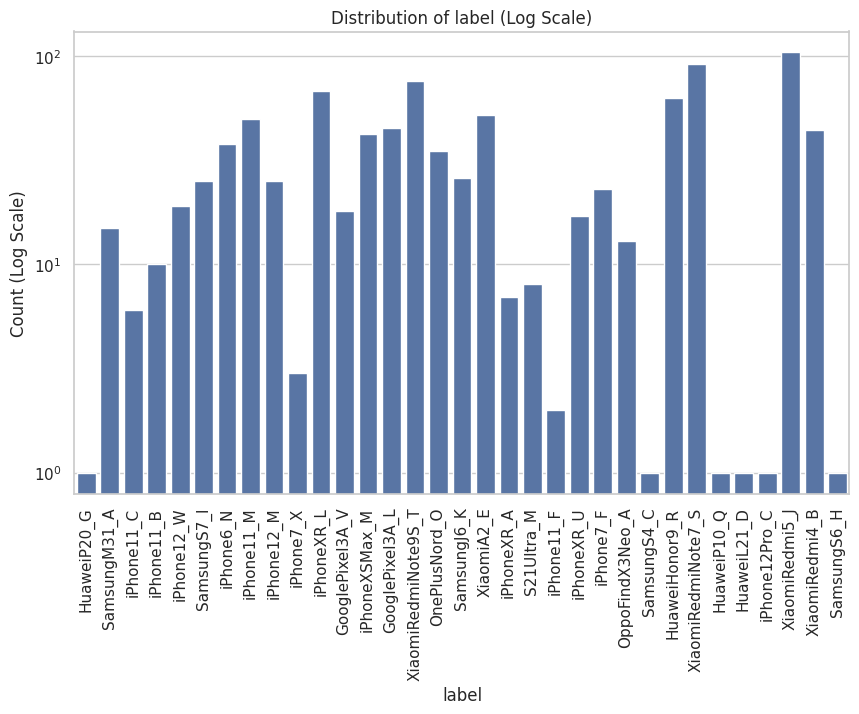

In [96]:
plotHelper.plot_label_distribution(df, "label", log_scale=True)

In [97]:
df["label"].unique()

array(['HuaweiP20_G', 'SamsungM31_A', 'iPhone11_C', 'iPhone11_B',
       'iPhone12_W', 'SamsungS7_I', 'iPhone6_N', 'iPhone11_M',
       'iPhone12_M', 'iPhone7_X', 'iPhoneXR_L', 'GooglePixel3A_V',
       'iPhoneXSMax_M', 'GooglePixel3A_L', 'XiaomiRedmiNote9S_T',
       'OnePlusNord_O', 'SamsungJ6_K', 'XiaomiA2_E', 'iPhoneXR_A',
       'S21Ultra_M', 'iPhone11_F', 'iPhoneXR_U', 'iPhone7_F',
       'OppoFindX3Neo_A', 'SamsungS4_C', 'HuaweiHonor9_R',
       'XiaomiRedmiNote7_S', 'HuaweiP10_Q', 'HuaweiL21_D',
       'iPhone12Pro_C', 'XiaomiRedmi5_J', 'XiaomiRedmi4_B', 'SamsungS6_H'],
      dtype=object)

In [98]:
df["label"].nunique()

33

In [99]:
df

,mac,len_ssid,len_sup_rates,supported_rates,len_ext_sup_rates,ext_sup_rates,len_ht_cap,ht_cap,len_ext_cap,ext_cap,len_vht_cap,vht_cap,len_vst,vst,len_ext_tags,ext_tags,dsss_parameter,label
0,00:be:3b:a2:a8:56,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010000100000001000110111111111111111111000000...,00000000,01111111,0000000000001000000011111000010000000001010000...,0000000000000000000000000000000000000000000000...,00001001,0000000010010000010011000000010000001000101111...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001000000010000000...,HuaweiP20_G
1,02:00:00:00:00:00,00000000,00001000,0000001000000100000010110001011000001100000100...,00000100,0011000001001000011000000110110000000000000000...,00011010,0010110100000001000101111111111100000000000000...,00000000,01111111,0000000100000000000010000000000000000000000000...,0000000000000000000000000000000000000000000000...,00000111,0000000001010000111100100000100000000000000100...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000100000001100000011000001...,SamsungM31_A
2,02:00:00:00:3e:b2,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_C
3,02:00:3a:5e:a1:f4,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone11_B
4,02:02:70:30:b6:43,00000000,00000100,1000001010000100100010111001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0010110101000000000110111111111100000000000000...,00000000,01111111,0000000000000000000010000000010000000000000000...,0000000000000000000000000000000000000000000000...,00000000,0000000000000000000000000000000000000000000000...,00011100,0010001100000001000010000000100000011000000000...,0000000000000000000000000000000000000000000000...,iPhone12_W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4756,fe:5b:80:1e:44:c4,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,1010110100000001000100111111111111111111000000...,00001100,01111111,0000000000000000000010101000001000000000010000...,1001001011111001100100010011001111111010111111...,00001000,0000000001010000111100100000100000000000001001...,00000011,0000001000000000000111110000000000000000000000...,0000000000000000000000010000000100000010000000...,XiaomiRedmiNote9S_T
4757,fe:5d:a5:9d:8d:f7,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,0110111000000001000000111111111100000000000000...,00000000,00000000,0000000000000000000000000000000000000000000000...,0000000000000000000000000000000000000000000000...,00000111,0000000001010000111100100000100000000000000000...,00000000,0000000000000000000000000000000000000000000000...,0000000100000001000000010000000100000010000000...,XiaomiA2_E
4768,fe:93:35:c4:ec:bb,00000000,00000100,0000001000000100000010110001011000000000000000...,00001000,0000110000010010000110000010010000110000010010...,00011010,1010110100000001000100111111111111111

In [100]:
df.to_csv("pairwise_boosting.csv", index=False)

## Generate `string_df`

`string_df` is now free of duplicates, i.e. probe burst with an identical configuration, and different `mac`

In [101]:
df["concatenated"] = (
    df.drop(columns=["label", "mac"]).astype(str).apply(lambda x: "".join(x), axis=1)
)

# If you want to keep the 'label' column in the final dataframe:
df_result = df[["label", "concatenated"]]

df_result = df_result.sort_values("label")

# Step 3: Save to CSV
output_file_path = (
    "../../data/interim/string_df.csv"  # replace with your desired output file path
)
df_result.to_csv(output_file_path, index=False)

/tmp/ipykernel_9397/2137173294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["concatenated"] = (


## Generate `pairs_df`

In [102]:
# Create all possible combinations of indexes (pairs)
index_pairs = list(combinations(df.index, 2))

# Separate matching and non-matching pairs
matching_pairs = []
non_matching_pairs = []

for pair in index_pairs:
    index1, index2 = pair
    label1 = df.loc[index1, "label"]
    label2 = df.loc[index2, "label"]

    if label1 == label2:
        matching_pairs.append((index1, index2, 1, label1, label2))
    else:
        non_matching_pairs.append((index1, index2, -1, label1, label2))

In [103]:
len(matching_pairs)

25203

In [104]:
len(non_matching_pairs)

408643

In [105]:
type(non_matching_pairs)

list

In [106]:
non_matching_pairs

[(0, 1, -1, 'HuaweiP20_G', 'SamsungM31_A'),
 (0, 2, -1, 'HuaweiP20_G', 'iPhone11_C'),
 (0, 3, -1, 'HuaweiP20_G', 'iPhone11_B'),
 (0, 4, -1, 'HuaweiP20_G', 'iPhone12_W'),
 (0, 5, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 6, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 7, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 8, -1, 'HuaweiP20_G', 'iPhone12_W'),
 (0, 9, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 10, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 11, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 12, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 13, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 14, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 15, -1, 'HuaweiP20_G', 'iPhone12_W'),
 (0, 17, -1, 'HuaweiP20_G', 'iPhone11_C'),
 (0, 18, -1, 'HuaweiP20_G', 'iPhone12_W'),
 (0, 21, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 22, -1, 'HuaweiP20_G', 'iPhone6_N'),
 (0, 23, -1, 'HuaweiP20_G', 'iPhone11_M'),
 (0, 24, -1, 'HuaweiP20_G', 'iPhone12_M'),
 (0, 25, -1, 'HuaweiP20_G', 'iPhone11_B'),
 (0, 27, -1, 'HuaweiP20_G', 'SamsungS7_I'),
 (0, 30,

In [107]:
matching_pairs

[(1, 194, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 230, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 235, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 296, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 890, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 961, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 1008, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 1122, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 1670, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 1817, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 2049, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 2558, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 4437, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (1, 4683, 1, 'SamsungM31_A', 'SamsungM31_A'),
 (2, 17, 1, 'iPhone11_C', 'iPhone11_C'),
 (2, 32, 1, 'iPhone11_C', 'iPhone11_C'),
 (2, 80, 1, 'iPhone11_C', 'iPhone11_C'),
 (2, 126, 1, 'iPhone11_C', 'iPhone11_C'),
 (2, 549, 1, 'iPhone11_C', 'iPhone11_C'),
 (3, 25, 1, 'iPhone11_B', 'iPhone11_B'),
 (3, 40, 1, 'iPhone11_B', 'iPhone11_B'),
 (3, 63, 1, 'iPhone11_B', 'iPhone11_B'),
 (3, 150, 1, 'iPho

In [108]:
# Convert lists to dataframes
columns = ["index1", "index2", "match", "device1", "device2"]
matching_df = pd.DataFrame(matching_pairs, columns=columns)
non_matching_df = pd.DataFrame(non_matching_pairs, columns=columns)

# Combine dataframes
df = pd.concat([matching_df, non_matching_df])

In [109]:
df

,index1,index2,match,device1,device2
0,1,194,1,SamsungM31_A,SamsungM31_A
1,1,230,1,SamsungM31_A,SamsungM31_A
2,1,235,1,SamsungM31_A,SamsungM31_A
3,1,296,1,SamsungM31_A,SamsungM31_A
4,1,890,1,SamsungM31_A,SamsungM31_A
...,...,...,...,...,...
408638,4757,4768,-1,XiaomiA2_E,XiaomiRedmiNote9S_T
408639,4757,4790,-1,XiaomiA2_E,iPhone6_N
408640,4768,4787,-1,XiaomiRedmiNote9S_T,XiaomiA2_E
408641,4768,4790,-1,XiaomiRedmiNote9S_T,iPhone6_N


In [110]:
from sklearn.utils import resample

In [111]:
# Separate matching and non-matching pairs
matching_df = df[df["match"] == 1]
non_matching_df = df[df["match"] == -1]

# Balance the number of matching and non-matching pairs
if len(matching_df) > len(non_matching_df):
    matching_df = resample(
        matching_df, replace=False, n_samples=len(non_matching_df), random_state=42
    )
else:
    non_matching_df = resample(
        non_matching_df, replace=False, n_samples=len(matching_df), random_state=42
    )

# Concatenate the balanced datasets
balanced_df = pd.concat([matching_df, non_matching_df])


# Ensure uniform appearance of devices
def balance_devices(df):
    device_counts = df["device1"].value_counts().to_dict()
    all_devices = list(device_counts.keys())
    device_appearances = {device: 0 for device in all_devices}

    balanced_rows = []

    for _, row in df.iterrows():
        device1, device2 = row["device1"], row["device2"]
        if device_appearances[device1] <= device_appearances[device2]:
            balanced_rows.append(row)
            device_appearances[device1] += 1
        else:
            balanced_rows.append(row)
            device_appearances[device2] += 1

    return pd.DataFrame(balanced_rows)


# Apply the function to balance device appearances
final_balanced_df = balance_devices(balanced_df)

print(final_balanced_df)

        index1  index2  match              device1              device2
0            1     194      1         SamsungM31_A         SamsungM31_A
1            1     230      1         SamsungM31_A         SamsungM31_A
2            1     235      1         SamsungM31_A         SamsungM31_A
3            1     296      1         SamsungM31_A         SamsungM31_A
4            1     890      1         SamsungM31_A         SamsungM31_A
...        ...     ...    ...                  ...                  ...
310940    2049    4756     -1         SamsungM31_A  XiaomiRedmiNote9S_T
226553    1100    1171     -1           iPhone11_M           XiaomiA2_E
172985     616    4678     -1           XiaomiA2_E      GooglePixel3A_L
122876     351    4211     -1  XiaomiRedmiNote9S_T       XiaomiRedmi4_B
188930     751    3557     -1      GooglePixel3A_V   XiaomiRedmiNote7_S

[50406 rows x 5 columns]


In [112]:
import matplotlib.pyplot as plt

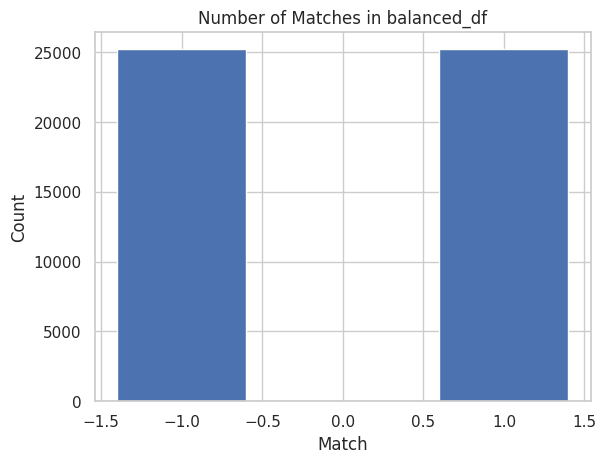

In [113]:
# Count the number of matches in balanced_df
match_counts = final_balanced_df["match"].value_counts()

# Create the bar plot
plt.bar(match_counts.index, match_counts.values)

# Set the labels and title
plt.xlabel("Match")
plt.ylabel("Count")
plt.title("Number of Matches in balanced_df")

# Show the plot
plt.show()

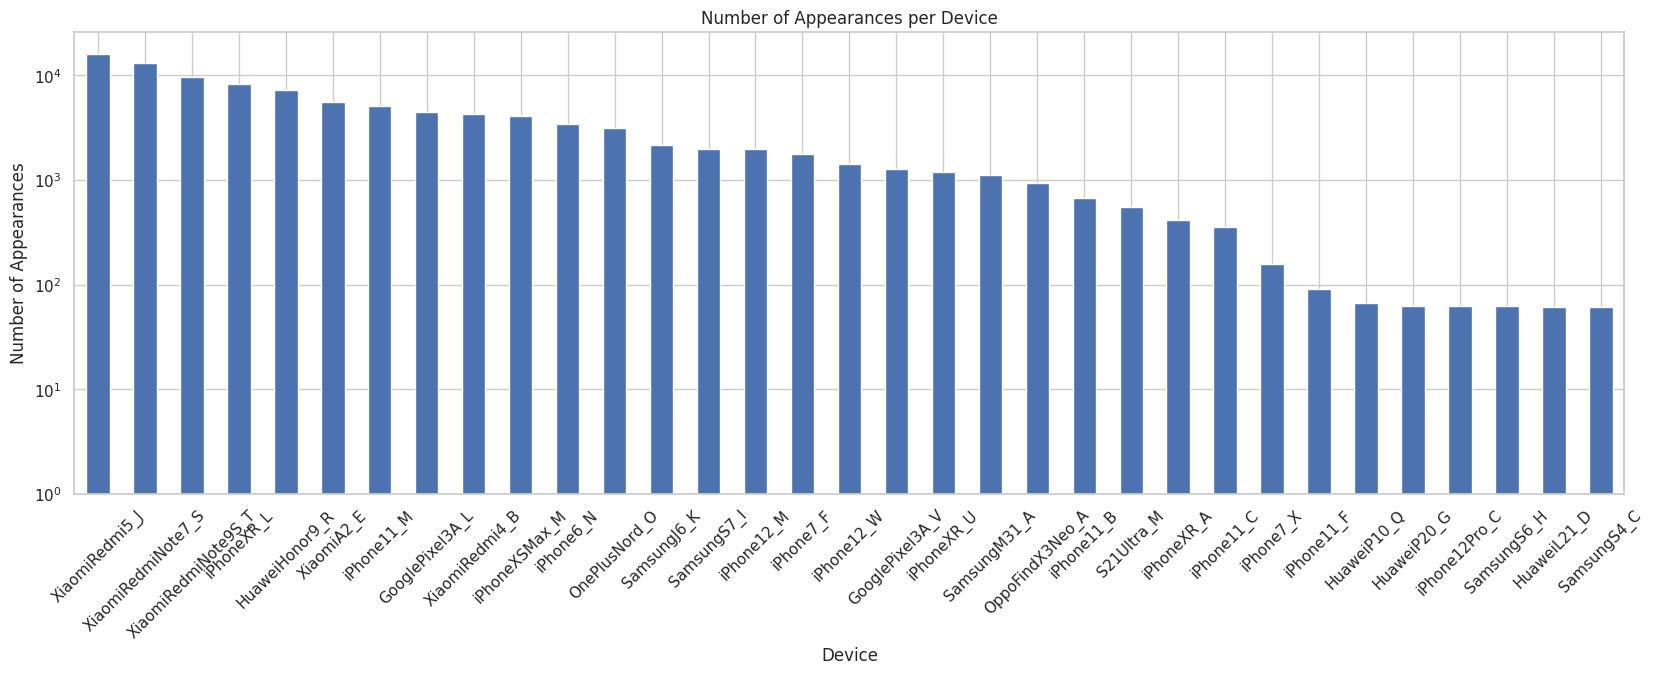

In [114]:
# Count occurrences in device1 and device2
device1_counts = final_balanced_df["device1"].value_counts()
device2_counts = final_balanced_df["device2"].value_counts()

# Combine the counts
combined_counts = device1_counts.add(device2_counts, fill_value=0)

# Plot the combined counts using a bar plot
plt.figure(figsize=(20, 6))
combined_counts.sort_values(ascending=False).plot(kind="bar", log=True)
plt.title("Number of Appearances per Device")
plt.xlabel("Device")
plt.ylabel("Number of Appearances")
plt.xticks(rotation=45)
plt.show()

In [115]:
# Separate matching and non-matching pairs
matching_df = final_balanced_df[final_balanced_df["match"] == 1]
non_matching_df = final_balanced_df[final_balanced_df["match"] == -1]

# Find the minimum number of appearances for any device
combined_counts = pd.concat(
    [final_balanced_df["device1"], final_balanced_df["device2"]]
).value_counts()
min_appearances = combined_counts.min()


# Function to downsample devices while balancing match
def downsample_device_balanced(match_df, non_match_df, device, min_appearances):
    device_match_rows = match_df[
        (match_df["device1"] == device) | (match_df["device2"] == device)
    ]
    device_non_match_rows = non_match_df[
        (non_match_df["device1"] == device) | (non_match_df["device2"] == device)
    ]

    if len(device_match_rows) > min_appearances // 2:
        device_match_rows = resample(
            device_match_rows,
            replace=False,
            n_samples=min_appearances // 2,
            random_state=42,
        )
    if len(device_non_match_rows) > min_appearances // 2:
        device_non_match_rows = resample(
            device_non_match_rows,
            replace=False,
            n_samples=min_appearances // 2,
            random_state=42,
        )

    return pd.concat([device_match_rows, device_non_match_rows])


# Downsample each device to match the minimum number of appearances while balancing matches
downsampled_dfs = []
for device in combined_counts.index:
    downsampled_dfs.append(
        downsample_device_balanced(
            matching_df, non_matching_df, device, min_appearances * 2
        )
    )

# Concatenate the downsampled DataFrames and drop duplicates
final_df = pd.concat(downsampled_dfs).drop_duplicates()

# Verify the number of appearances per device and match balance in the final DataFrame
final_device1_counts = final_df["device1"].value_counts()
final_device2_counts = final_df["device2"].value_counts()
final_combined_counts = final_device1_counts.add(final_device2_counts, fill_value=0)
final_match_counts = final_df["match"].value_counts()

# Display the final balanced DataFrame and the counts
print("Final combined device counts:")
print(final_combined_counts)
print("\nFinal match counts:")
print(final_match_counts)
print("\nFinal balanced DataFrame:")
print(final_df)

Final combined device counts:
GooglePixel3A_L        283.0
GooglePixel3A_V        209.0
HuaweiHonor9_R         305.0
HuaweiL21_D             60.0
HuaweiP10_Q             60.0
HuaweiP20_G             60.0
OnePlusNord_O          247.0
OppoFindX3Neo_A        204.0
S21Ultra_M             135.0
SamsungJ6_K            240.0
SamsungM31_A           219.0
SamsungS4_C             60.0
SamsungS6_H             60.0
SamsungS7_I            228.0
XiaomiA2_E             294.0
XiaomiRedmi4_B         280.0
XiaomiRedmi5_J         389.0
XiaomiRedmiNote7_S     365.0
XiaomiRedmiNote9S_T    331.0
iPhone11_B             165.0
iPhone11_C              99.0
iPhone11_F              64.0
iPhone11_M             276.0
iPhone12Pro_C           60.0
iPhone12_M             239.0
iPhone12_W             224.0
iPhone6_N              275.0
iPhone7_F              234.0
iPhone7_X               72.0
iPhoneXR_A             119.0
iPhoneXR_L             325.0
iPhoneXR_U             202.0
iPhoneXSMax_M          275.0
Name: count, 

In [116]:
final_df

,index1,index2,match,device1,device2
24338,3837,3884,1,XiaomiRedmi5_J,XiaomiRedmi5_J
16124,3042,3498,1,XiaomiRedmi5_J,XiaomiRedmi5_J
14187,2956,4214,1,XiaomiRedmi5_J,XiaomiRedmi5_J
22728,3509,4164,1,XiaomiRedmi5_J,XiaomiRedmi5_J
16158,3042,3935,1,XiaomiRedmi5_J,XiaomiRedmi5_J
...,...,...,...,...,...
309941,2027,4209,-1,HuaweiL21_D,HuaweiHonor9_R
199764,845,2027,-1,iPhone7_X,HuaweiL21_D
309869,2027,3721,-1,HuaweiL21_D,XiaomiRedmi5_J
307733,1999,2027,-1,iPhoneXR_L,HuaweiL21_D


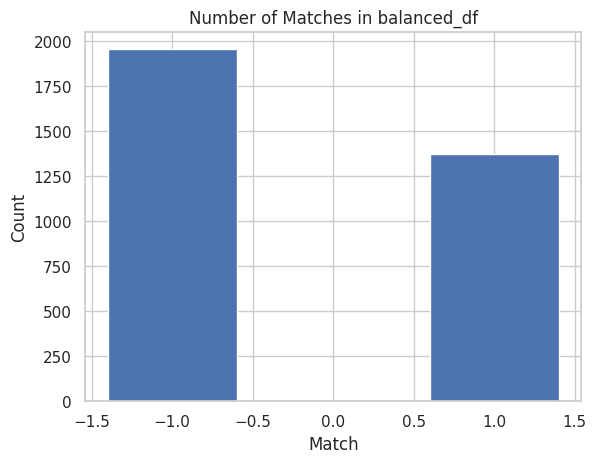

In [117]:
# Count the number of matches in balanced_df
match_counts = final_df["match"].value_counts()

# Create the bar plot
plt.bar(match_counts.index, match_counts.values)

# Set the labels and title
plt.xlabel("Match")
plt.ylabel("Count")
plt.title("Number of Matches in balanced_df")

# Show the plot
plt.show()

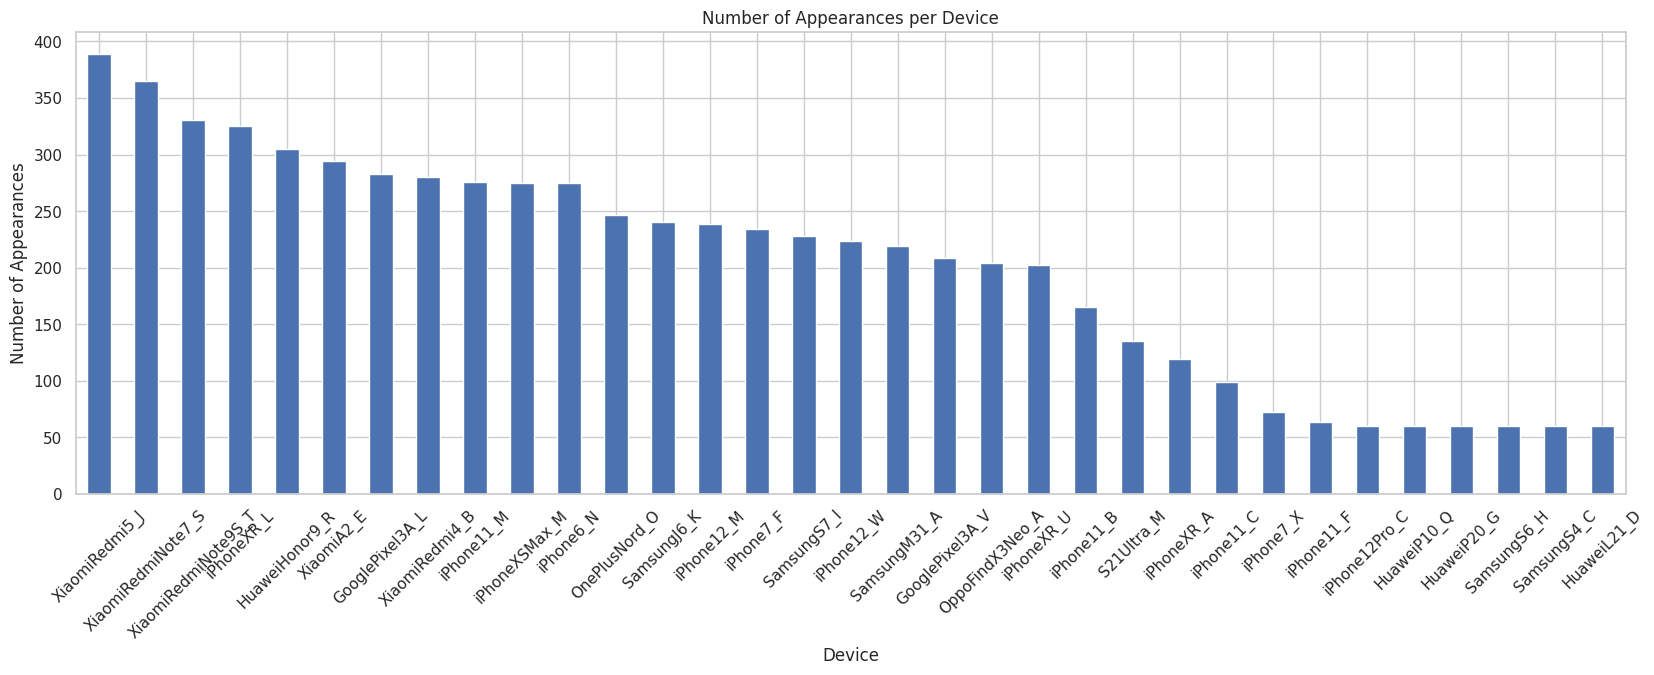

In [118]:
# Count occurrences in device1 and device2
device1_counts = final_df["device1"].value_counts()
device2_counts = final_df["device2"].value_counts()

# Combine the counts
combined_counts = device1_counts.add(device2_counts, fill_value=0)

# Plot the combined counts using a bar plot
plt.figure(figsize=(20, 6))
combined_counts.sort_values(ascending=False).plot(kind="bar")
plt.title("Number of Appearances per Device")
plt.xlabel("Device")
plt.ylabel("Number of Appearances")
plt.xticks(rotation=45)
plt.show()